In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ML functions and plotting libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [4]:
# file naming variables
latest_version = 'df_2022-11-27'
location = '/Users/Sim/Documents/Other/Programming/Personal Projects/House price prediction'

### 1. Loading the latest data

In [5]:
df=pd.read_csv(f'{location}/{latest_version}.csv')
len(df)

2954

In [6]:
df.tail(5)

,Unnamed: 0,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,Portered,Contract_Type,Outcode,Outcode2,Postcode,Centrality,North,Links,Date_Scraped
2949,571,20221031.0,515000.0,City Thameslink Station,0.1,Apartment,1.0,1.0,NaN,0.0,0.0,Leasehold,EC4M,EC4,EC4M7AS,1.942396,1.0,https://www.rightmove.co.uk/properties/1285682...,2022-11-27
2950,572,20221030.0,685000.0,Ladbroke Grove Station,0.3,Flat,1.0,1.0,NaN,0.0,0.0,Leasehold,W10,W10,W105PJ,5.945918,1.0,https://www.rightmove.co.uk/properties/1285622...,2022-11-27
2951,573,20221030.0,700000.0,Upper Holloway Station,0.4,Apartment,2.0,2.0,900.0,1.0,0.0,Freehold,N7,N7,N76RE,6.164741,1.0,https://www.rightmove.co.uk/properties/1285540...,2022-11-27
2952,574,20221031.0,775000.0,Southwark Station,0.3,Apartment,1.0,1.0,NaN,1.0,1.0,Leasehold,SE1,SE1,SE19JF,1.863147,0.0,https://www.rightmove.co.uk/properties/1285788...,2022-11-27
2953,575,20221109.0,750000.0,Pimlico Station,0.1,Flat,2.0,2.0,717.0,1.0,0.0,Leasehold,SW1V,SW1,SW1V3QT,2.323050,1.0,https://www.rightmove.co.uk/properties/1289183...,2022-11-27


### 2. Pre-processing the data

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
df['NearStat'].value_counts().head(10)

Pimlico Station                        122
Westbourne Park Station                118
Ladbroke Grove Station                  88
Queen's Park Station                    85
Vauxhall Station                        73
Essex Road Station                      70
Angel Station                           66
Caledonian Road & Barnsbury Station     64
Kilburn High Road Station               64
Chalk Farm Station                      63
Name: NearStat, dtype: int64

In [9]:
df['Outcode2'].value_counts()

NW6     269
N1      250
SW1     215
W2      210
W9      201
SE1     184
N7      163
NW1     151
NW3     144
EC1     132
NW8      91
W10      89
WC1      84
NW5      82
SW3      74
SW11     73
W11      73
W1       67
SE11     59
SW8      52
N19      43
EC2      41
SW5      37
SW7      32
W8       31
WC2      25
EC4      22
N5       22
SW10     13
N6        6
SE17      5
E1        3
EC3       2
NW2       2
E2        2
E14       2
NW10      1
SW6       1
BR3       1
Name: Outcode2, dtype: int64

In [10]:
# Getting dummies vars
df2 = pd.concat([df, pd.get_dummies(df.iloc[:,2])], axis=1) #nearest station
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,4])], axis=1) #prop_type
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,10])], axis=1) #contract
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,12])], axis=1) #outcode2
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,17])], axis=1) #scraped_date

df2.head(3)

,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,Portered,...,W11,W2,W8,W9,WC1,WC2,2022-09-02,2022-10-23,2022-10-29,2022-11-27
0,20211111.0,600000.0,Barbican Station,0.4,Apartment,1.0,1.0,NaN,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,20220826.0,450000.0,Angel Station,0.2,Apartment,1.0,1.0,NaN,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,20220318.0,600000.0,Battersea Power Underground Station,0.2,Flat,1.0,1.0,NaN,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0


### 3. Variable selection

In [11]:
# Leave out 'Studio', 'Freehold', stations, a bunch of postcodes

variables = ['Price','StatDist(miles)','Bedrooms','Bathrooms','Outdoor','Portered','Apartment','Flat','House','Maisonette','Mews',
             'Terraced','Leasehold','NW6','SW1','N1','W2','W9','SE1','N7','NW1','EC1','NW3','SW11','WC1','W1',
             'NW8','W10','SW3','NW5','W11','SE11','North','Centrality','Floor_Size', '2022-10-23','2022-10-29','2022-11-27']
stations = ['Edgware Road (Circle, District, Hammersmith & City) Station',
'St. John\'s Wood Station','Marylebone Station','Paddington Station',                                             
'Edgware Road (Bakerloo) Station', 'Warwick Avenue Station','Lancaster Gate Station',
'Marble Arch Station','Maida Vale Station',
'Baker Street Station','Royal Oak Station']

df_varselect = df2[variables].dropna()
#df_varselect2 =df2[stations]
#df_varselect2 = pd.concat([df_varselect, df_varselect2], axis=1).dropna()
#df_varselect2
df_varselect['Centrality2'] = df_varselect['Centrality'] **2
df_varselect['Floor_Size2'] = df_varselect['Floor_Size'] **2

df_varselect

,Price,StatDist(miles),Bedrooms,Bathrooms,Outdoor,Portered,Apartment,Flat,House,Maisonette,...,W11,SE11,North,Centrality,Floor_Size,2022-10-23,2022-10-29,2022-11-27,Centrality2,Floor_Size2
7,795000.0,0.5,2.0,2.0,1.0,1.0,1,0,0,0,...,0,0,1.0,3.877639,814.0,0,0,0,15.036087,662596.0
11,460000.0,0.5,1.0,1.0,1.0,0.0,0,1,0,0,...,0,0,1.0,4.036900,557.0,0,0,0,16.296563,310249.0
12,485000.0,0.4,1.0,1.0,1.0,0.0,0,1,0,0,...,0,0,1.0,2.593857,474.0,0,0,0,6.728095,224676.0
13,800000.0,0.2,2.0,2.0,1.0,0.0,0,1,0,0,...,0,0,1.0,4.099568,936.0,0,0,0,16.806457,876096.0
14,530000.0,0.1,1.0,1.0,0.0,1.0,1,0,0,0,...,0,0,1.0,5.268633,590.0,0,0,0,27.758498,348100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,535000.0,0.1,3.0,1.0,1.0,0.0,0,1,0,0,...,0,0,1.0,5.632120,841.0,0,0,1,31.720771,707281.0
2944,720000.0,0.5,1.0,1.0,1.0,1.0,0,1,0,0,...,0,0,1.0,4.271999,624.0,0,0,1,18.249979,389376.0
2945,450000.0,0.2,1.0,1.0,1.0,0.0,0,1,0,0,...,1,0,1.0,5.517607,500.0,0,0,1,30.443983,250000.0
2951,700000.0,0.4,2.0,2.0,1.0,0.0,1,0,0,0,...,0,0,1.0,6.164741,900.0,0,0,1,38.004033,810000.0


In [12]:
# Create feature and target arrays
X = np.array(df_varselect.iloc[:,1:df_varselect.shape[1]])
y = np.array(df_varselect.iloc[:,0])

### 4. Econometric linear regressions

In [13]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.3653578983869511

In [14]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     14.78
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           5.69e-74
Time:                        20:07:22   Log-Likelihood:                -13292.
No. Observations:                1041   AIC:                         2.666e+04
Df Residuals:                    1001   BIC:                         2.686e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.351e+05   4.13e+04      8.107      0.0

In [15]:
df_varselect.columns[[1,3,4,5,6,8,12,13,14,15,17,18,19,20,21,22,23,24,25,29,31,33,34,37,38]]

Index(['StatDist(miles)', 'Bathrooms', 'Outdoor', 'Portered', 'Apartment',
       'House', 'Leasehold', 'NW6', 'SW1', 'N1', 'W9', 'SE1', 'N7', 'NW1',
       'EC1', 'NW3', 'SW11', 'WC1', 'W1', 'NW5', 'SE11', 'Centrality',
       'Floor_Size', '2022-11-27', 'Centrality2'],
      dtype='object')

In [18]:
best_vars = [1,3,4,5,6,8,12,13,14,15,17,18,19,20,21,22,23,24,25,29,31,33,34,38]
df_varselect.iloc[:,best_vars].tail()

,StatDist(miles),Bathrooms,Outdoor,Portered,Apartment,House,Leasehold,NW6,SW1,N1,...,EC1,NW3,SW11,WC1,W1,NW5,SE11,Centrality,Floor_Size,Centrality2
2929,0.1,1.0,1.0,0.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,5.632120,841.0,31.720771
2944,0.5,1.0,1.0,1.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,4.271999,624.0,18.249979
2945,0.2,1.0,1.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,5.517607,500.0,30.443983
2951,0.4,2.0,1.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,6.164741,900.0,38.004033
2953,0.1,2.0,1.0,0.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2.323050,717.0,5.396560


### 5. Shuffling and Splitting data into train, test and validation sets

In [71]:
# Shuffling data (to ensure random order) and performing 0.5 : 0.25 : 0.25 train-validation-test set splits
X_train, X_non, y_train, y_non = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_non, y_non, test_size=0.5, shuffle=True, random_state=1)

# Combining train and val for cross validation approach
X_tv, y_tv = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)]), pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)])

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(X_tv.shape)
print(y_tv.shape)

(520, 39)
(260, 39)
(261, 39)
(520,)
(260,)
(261,)
(780, 39)
(780, 1)


In [72]:
# Normalising
scaler = preprocessing.StandardScaler().fit(X_train)
# Apply the scaling object to both train/validation/test sets
X_train_new = scaler.transform(X_train)
X_val_new = scaler.transform(X_val)
X_test_new = scaler.transform(X_test)
X_tv_new = scaler.transform(X_tv)

### 6. Model Training

#### 6A. Decision Tree Model
First we train a decision tree classifier. Using the loop in the code below, we train multiple decision trees of varying max_depths and choose the model that maximises validation set accuracy (i.e. minimises out of sample error).

In [48]:
train_acc_dict = {}
val_acc_dict = {}

for d in range(1, len(variables)):
    reg = DecisionTreeRegressor(max_depth=d, random_state=123)
    reg = reg.fit(X_train, y_train)
    
    train_acc, val_acc = reg.score(X_train, y_train), reg.score(X_val, y_val)
    train_acc_dict[d], val_acc_dict[d] = train_acc, val_acc
    
best_depth = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_depth], 3)
print('The maximum validation set accuracy - %s - occurs at depth = %s' % (best_acc, best_depth))

The maximum validation set accuracy - 0.205 - occurs at depth = 4


In [73]:
# DT error - test set
best_dt = DecisionTreeRegressor(random_state=123, max_depth = best_depth)
best_dt.fit(X_train_new, y_train)
best_dt.score(X_val_new, y_val)

0.3559610836302558

In [74]:
# Using grid search and 10-fold CV instead

param_grid = {'max_depth': [1,3,4,5,6,8,10,20,30]}

dt = DecisionTreeRegressor()

grid = GridSearchCV(dt, param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid.fit(X_tv_new, y_tv)
score = grid.score(X_tv_new, y_tv)
param = grid.best_params_
print('Best val accuracy - %s - occurs at depth = %s' % (score, param))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best val accuracy - 0.3559610836302558 - occurs at depth = {'max_depth': 4}


#### 6B. Lasso Model

For this we use a subset of the best columns.

In [46]:
train_acc_dict = {}
val_acc_dict = {}

for a in np.arange(0.1, 10, 0.1):
    reg = Lasso(alpha=a, random_state=123)
    reg = reg.fit(X_train_new, y_train)
    
    train_acc, val_acc = reg.score(X_train_new, y_train), reg.score(X_val_new, y_val)
    train_acc_dict[a], val_acc_dict[a] = train_acc, val_acc
    
best_alpha = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_alpha], 3)
print('The maximum validation set accuracy - %s - occurs at alpha = %s' % (best_acc, best_alpha))

The maximum validation set accuracy - 0.31 - occurs at alpha = 0.1


Text(1.1, 0.32, '(alpha=0.1, accuracy=0.31)')

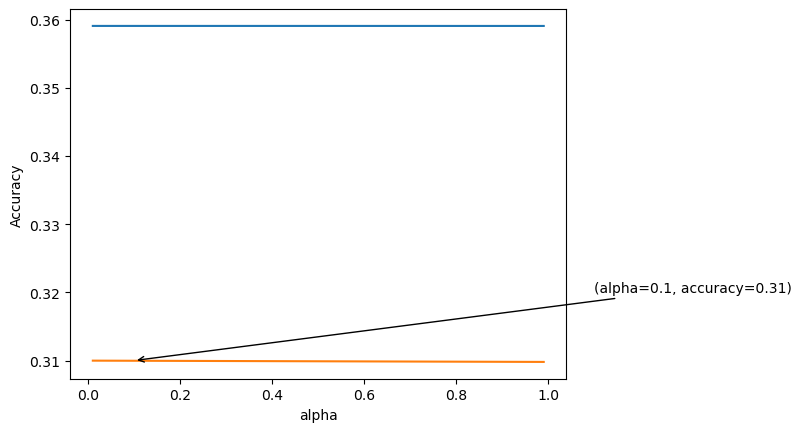

In [47]:
n_est = [x for x in np.arange(0.01, 1, 0.01)]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
ax.annotate('(alpha=%s, accuracy=%s)' % (best_alpha, best_acc), xy=(best_alpha, best_acc), xytext=(best_alpha + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [121]:
# Building subset of best predictors for Lasso
best_predictors = abs(X_tv.corrwith(y_tv[0])).sort_values(ascending = False)
best_predictors.iloc[0:10]

33    0.412189
38    0.380892
2     0.349276
1     0.254772
5     0.123999
4     0.122588
6     0.118270
3     0.089034
10    0.082265
24    0.077023
dtype: float64

In [81]:
# Using grid search and 10-fold CV instead

param_grid = {'alpha': np.arange(0.001, 0.1, 0.002)}

grid = GridSearchCV(Lasso(), param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid.fit(X_tv_new, y_tv)
score = grid.score(X_tv_new, y_tv)
param = grid.best_params_
print('Best val accuracy - %s - occurs at alpha = %s' % (score, param))
# 0.3615268259069946
# 0.3615625840150405

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best val accuracy - 0.3615625840150405 - occurs at alpha = {'alpha': 0.099}


#### 6C. Random Forest Model
Next we train a random forest classifier. Using the loop in the code below, we train multiple RFs of varying n_estimators and choose the model that maximises validation set accuracy (i.e. minimises out of sample error).

In [34]:
# Choosing best no. of estimators (trees)
train_acc_dict = {}
val_acc_dict = {}

for n in range(2, 101):
    rf = RandomForestRegressor(n_estimators=n, random_state=123)
    rf = rf.fit(X_train, y_train.ravel())
    train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
    train_acc_dict[n], val_acc_dict[n] = train_acc, val_acc
    
best_trees = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_trees], 4)
print('The maximum validation set accuracy - %s - occurs at no. trees = %s' % (best_acc, best_trees))

The maximum validation set accuracy - 0.3816 - occurs at no. trees = 98


Text(99, 0.3916, '(no. trees=98, accuracy=0.3816)')

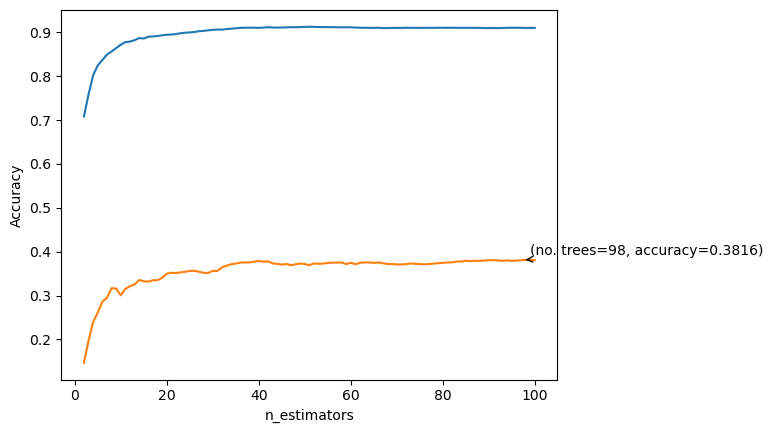

In [35]:
n_est = [x for x in range(2, 101)]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
ax.annotate('(no. trees=%s, accuracy=%s)' % (best_trees, best_acc), xy=(best_trees, best_acc), xytext=(best_trees + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [36]:
# Choosing best max tree depth

train_acc_dict = {}
val_acc_dict = {}

for n in range(1, len(variables)):
    rf = RandomForestRegressor(n_estimators=best_trees, random_state=123, max_depth = n)
    rf = rf.fit(X_train, y_train)
    train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
    train_acc_dict[n], val_acc_dict[n] = train_acc, val_acc

best_depth = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_depth], 4)
print('The maximum validation set accuracy - %s - occurs at max depth = %s' % (best_acc, best_depth))

The maximum validation set accuracy - 0.382 - occurs at max depth = 29


Text(30, 0.392, '(max_depth=29, accuracy=0.382)')

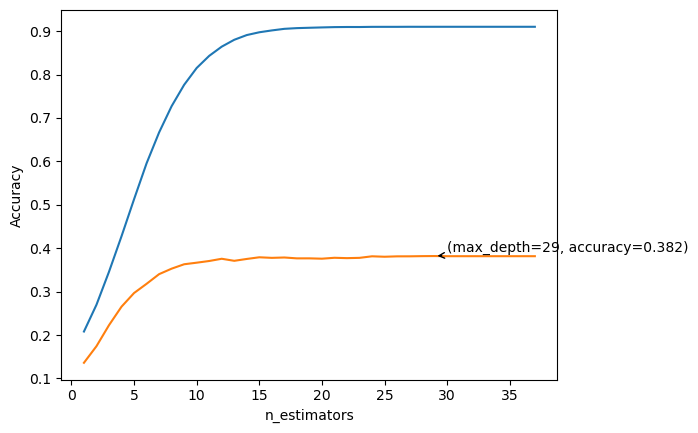

In [37]:
n_est = [x for x in range(1, len(variables))]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
ax.annotate('(max_depth=%s, accuracy=%s)' % (best_depth, best_acc), xy=(best_depth, best_acc), xytext=(best_depth + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [38]:
# Combining no. tress and depth - choosing best of both!
train_acc_dict = {}
val_acc_dict = {}

for depths in range(5, (len(variables)-2)):
    for trees in range(max(best_trees-15,1), best_trees +15):
        rf = RandomForestRegressor(n_estimators=trees, random_state=123, max_depth = depths)
        rf = rf.fit(X_train, y_train)
        train_acc, val_acc = rf.score(X_train, y_train), rf.score(X_val, y_val)
        train_acc_dict[(depths,trees)], val_acc_dict[(depths,trees)] = train_acc, val_acc

best_depth_trees = max(val_acc_dict, key=val_acc_dict.get)
best_depth2, best_trees2 = best_depth_trees[0], best_depth_trees[1]
best_acc = round(val_acc_dict[best_depth_trees], 4)
print('The maximum validation set accuracy - %s - occurs at depth = %s and trees = %s' % (best_acc, best_depth2, best_trees2))

The maximum validation set accuracy - 0.3825 - occurs at depth = 29 and trees = 104


### 7. Comparing tuned, best in class models

In [43]:
# RF test set error
best_rf = RandomForestRegressor(random_state=123, n_estimators=best_trees2, max_depth = best_depth2)
best_rf.fit(X_train, y_train)
best_rf.score(X_test, y_test)

0.34234666116981716

In [48]:
# Lasso test set error
best_lr = Lasso(random_state=123, alpha=best_alpha)
best_lr.fit(X_train_new, y_train)
best_lr.score(X_test_new, y_test)

0.29492052990350826

### 8. Extra digging into models/predictions

In [49]:
y_pred = best_lr.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Lasso has MAE = £%sk' % (int(str(round(mae))[:-3])))

Lasso has MAE = £72k


In [50]:
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest has MAE = £%sk' % (int(str(round(mae))[:-3])))

Random Forest has MAE = £68k


In [233]:
X[3,:]

array([2.00000000e-01, 2.00000000e+00, 2.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       4.09956788e+00, 9.36000000e+02, 0.00000000e+00, 0.00000000e+00])

In [51]:
df_varselect.iloc[[3],:]

,Price,StatDist(miles),Bedrooms,Bathrooms,Outdoor,Portered,Apartment,Flat,House,Maisonette,...,W11,SE11,North,Centrality,Floor_Size,2022-10-23,2022-10-29,2022-11-27,Centrality2,Floor_Size2
13,800000.0,0.2,2.0,2.0,1.0,0.0,0,1,0,0,...,0,0,1.0,4.099568,936.0,0,0,0,16.806457,876096.0


In [52]:
best_rf.predict(X[3].reshape(1, -1))

array([783287.5])